### Imports

In [67]:
from mpl_toolkits import mplot3d
from sklearn.metrics import silhouette_score
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
from utils.utils import *

import hdbscan
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import sys


%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.39 ms (started: 2023-05-18 22:27:10 -05:00)


### Parameters

In [110]:
import json
  
# Opening JSON file
file = open("parameters.json")
params = json.load(file)

dir = os.path.dirname(os.getcwd())
print(dir)

method = params["method"][params["method_idx"]]
print("Method:\t\t", method)

group = params["group"][params["group_idx"]]
print("Group:\t\t", group)

subgroups = [str(k + 1) for k in range(group[1])]
print("Subgroup:\t", subgroups)

dimensions = params["dimensions"]
print("Dimensions:\t", dimensions)

/home/ealvarez/Project/GNN_Filter
Method:		 dgi
Group:		 ['WT', 5]
Subgroup:	 ['1', '2', '3', '4', '5']
Dimensions:	 [3]
time: 3.29 ms (started: 2023-05-19 10:11:05 -05:00)


### Edge embeddings

In [69]:
# Get edges embeddings

for dimension in tqdm(dimensions):
    # Get embeddings    
    for i in tqdm(subgroups):
        # Read dataset
        df_node_embeddings = pd.read_csv("{}/output_{}/node_embeddings/{}_node-embeddings_{}_{}.csv".format(dir, method, group[0], dimension, i), index_col=0)
        df_edges = pd.read_csv("{}/output_preprocessing/graph_data/{}_edges_data_{}.csv".format(dir, group[0], i))
        
        # Get edges embeddings
        list_df_edge_embeddings, list_edge_embeddings_legend = edge2vecx([df_node_embeddings], [df_edges], [""])
        for j in range(len(list_df_edge_embeddings)):
            list_df_edge_embeddings[j].to_csv("{}/output_{}/edge_embeddings/{}_edge-embeddings_{}_{}_{}.csv".format(dir, method, group[0], dimension, i, list_edge_embeddings_legend[j]), index=True)

100%|██████████| 1/1 [16:11<00:00, 971.35s/it]

time: 16min 11s (started: 2023-05-18 22:27:10 -05:00)


In [70]:
df_edge_embeddings = pd.read_csv("{}/output_{}/edge_embeddings/{}_edge-embeddings_{}_{}_{}.csv".format(dir, method, group[0], 3, 1, "L2"), index_col=0)
df_edge_embeddings

,0,1,2
"(0, 1)",0.102109,0.109179,1.723577
"(0, 2)",0.468830,0.391306,1.381330
"(0, 3)",0.051990,1.046764,1.707938
"(0, 4)",0.062466,0.654958,0.015839
"(0, 5)",0.256129,0.024957,4.956828
...,...,...,...
"(6180, 6181)",0.000137,0.067087,0.006492
"(6185, 6212)",0.070517,0.053576,0.180426
"(6191, 6192)",0.002494,0.035250,0.276322
"(6210, 6211)",0.013964,0.525821,0.021824


time: 1.07 s (started: 2023-05-18 22:43:22 -05:00)


### Join embeddings

In [71]:
for dimension in tqdm(dimensions):
    df_edge_embeddings_join = pd.DataFrame()
    for i in tqdm(subgroups):
        # Read dataset
        df_edge_embeddings = pd.read_csv("{}/output_{}/edge_embeddings/{}_edge-embeddings_{}_{}_{}.csv".format(dir, method, group[0], dimension, i, "L2"), index_col=0)
        df_edge_embeddings["subgroup"] = [i] * len(df_edge_embeddings)

        df_edge_embeddings_join = pd.concat([df_edge_embeddings_join, df_edge_embeddings])
    df_edge_embeddings_join.to_csv("{}/output_{}/edge_embeddings_join/{}_edge-embeddings_join_{}_{}.csv".format(dir, method, group[0], dimension, "L2"), index=True)

100%|██████████| 1/1 [00:50<00:00, 50.10s/it]

time: 50.1 s (started: 2023-05-18 22:43:23 -05:00)


In [72]:
df_edge_embeddings_join = pd.read_csv("{}/output_{}/edge_embeddings_join/{}_edge-embeddings_join_{}_{}.csv".format(dir, method, group[0], 3, "L2"), index_col=0)
df_edge_embeddings_join

,0,1,2,subgroup
"(0, 1)",0.102109,0.109179,1.723577,1
"(0, 2)",0.468830,0.391306,1.381330,1
"(0, 3)",0.051990,1.046764,1.707938,1
"(0, 4)",0.062466,0.654958,0.015839,1
"(0, 5)",0.256129,0.024957,4.956828,1
...,...,...,...,...
"(6173, 6174)",0.001269,0.027329,0.032441,5
"(6203, 6204)",0.227286,0.589844,0.349518,5
"(6203, 6218)",0.426164,0.192750,0.059073,5
"(6211, 6215)",0.000050,0.042607,0.034490,5


time: 10.5 s (started: 2023-05-18 22:44:13 -05:00)


  0%|          | 0/1 [00:00<?, ?it/s]

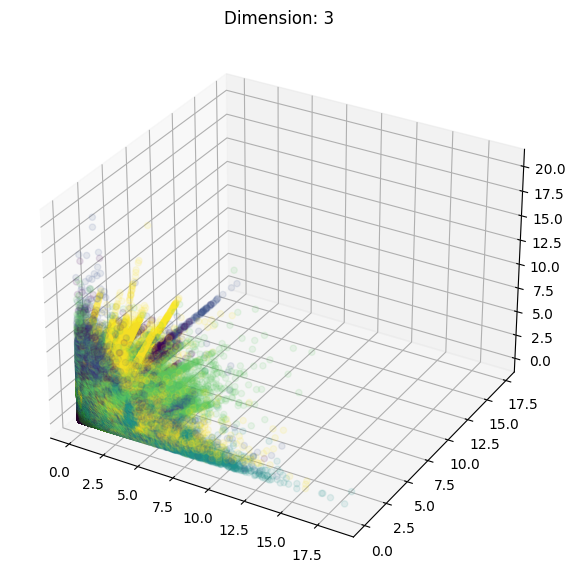

100%|██████████| 1/1 [03:04<00:00, 184.28s/it]

time: 3min 4s (started: 2023-05-18 22:44:24 -05:00)


In [73]:
# Plot join

for dimension in tqdm(dimensions):
    # Read dataset
    df_edge_embeddings_join = pd.read_csv("{}/output_{}/edge_embeddings_join/{}_edge-embeddings_join_{}_{}.csv".format(dir, method, group[0], dimension, "L2"), index_col=0)

    x = df_edge_embeddings_join.iloc[:, 0]
    y = df_edge_embeddings_join.iloc[:, 1]
    z = df_edge_embeddings_join.iloc[:, 2]

    # Creating figure
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes(projection ="3d")

    # Creating plot
    ax.scatter3D(x, y, z, c=df_edge_embeddings_join.iloc[:, -1], alpha=0.1)
    plt.title("Dimension: {}".format(dimension))

    # show plot
    plt.show()

### Clustering

In [74]:
# silhouette_score(X_train.iloc[:, :-1], X_train.iloc[:, -1])

time: 442 µs (started: 2023-05-18 22:47:28 -05:00)


In [75]:
# Outlier detection

for dimension in tqdm(dimensions):
    df_edge_embeddings_join = pd.read_csv("{}/output_{}/edge_embeddings_join/{}_edge-embeddings_join_{}_{}.csv".format(dir, method, group[0], dimension, "L2"), index_col=0)
    
    X_train = df_edge_embeddings_join.iloc[:, :-1]
    clusterer = hdbscan.HDBSCAN(min_cluster_size=100, core_dist_n_jobs=-1).fit(X_train)

100%|██████████| 1/1 [40:29<00:00, 2429.95s/it]

time: 40min 29s (started: 2023-05-18 22:47:28 -05:00)


In [76]:
threshold = pd.Series(clusterer.outlier_scores_).quantile(0.9)
outliers = np.where(clusterer.outlier_scores_ > threshold)[0]

print(len(outliers))
outliers

1223483


array([       1,        8,       28, ..., 12234778, 12234785, 12234793])

time: 23.9 s (started: 2023-05-18 23:27:58 -05:00)


Total: 12234830
Num. of outliers: 1223483
Num. of no-outliers: 10222024


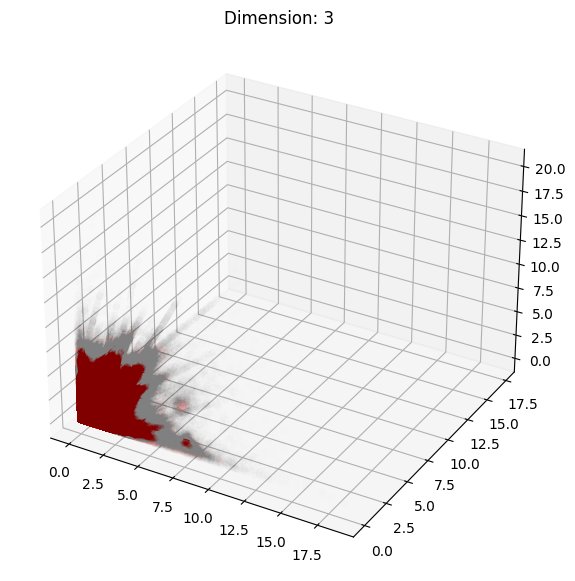

time: 2min 53s (started: 2023-05-18 23:28:22 -05:00)


In [77]:
print("Total:", len(df_edge_embeddings_join))
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

temp = df_edge_embeddings_join.iloc[outliers, :]
x = temp.iloc[:, 0]
y = temp.iloc[:, 1]
z = temp.iloc[:, 2]
ax.scatter3D(x, y, z, c="gray", alpha=0.005)
print("Num. of outliers:", len(temp))

temp = df_edge_embeddings_join.drop(df_edge_embeddings_join.index[outliers])
x = temp.iloc[:, 0]
y = temp.iloc[:, 1]
z = temp.iloc[:, 2]
ax.scatter3D(x, y, z, c="red", alpha=0.005)
print("Num. of no-outliers:", len(temp))

plt.title("Dimension: {}".format(dimension))
plt.show()

###  Filter common edges

In [78]:
df_edge_embeddings_join_filter = df_edge_embeddings_join.drop(df_edge_embeddings_join.index[outliers])
df_edge_embeddings_join_filter.to_csv("{}/output_{}/edges_filter/{}_edges-filter_{}_{}.csv".format(dir, method, group[0], 3, "L2"), index=True)
df_edge_embeddings_join_filter

,0,1,2,subgroup
"(1, 3180)",0.016318,0.190800,1.876853,1
"(1, 3035)",0.075105,0.007758,0.844440,1
"(1, 2364)",0.038833,0.341514,0.314578,1
"(1, 2687)",0.054661,0.332075,0.692657,1
"(1, 2690)",0.010190,0.427282,0.452783,1
...,...,...,...,...
"(6173, 6174)",0.001269,0.027329,0.032441,5
"(6203, 6204)",0.227286,0.589844,0.349518,5
"(6203, 6218)",0.426164,0.192750,0.059073,5
"(6211, 6215)",0.000050,0.042607,0.034490,5


time: 49.3 s (started: 2023-05-18 23:31:16 -05:00)


In [79]:
df_edge_embeddings_join_filter = pd.read_csv("{}/output_{}/edges_filter/{}_edges-filter_{}_{}.csv".format(dir, method, group[0], 3, "L2"), index_col=0)
df_edge_embeddings_join_filter.set_index([pd.Index([eval(item) for item in df_edge_embeddings_join_filter.index])], inplace=True)
df_edge_embeddings_join_filter.to_csv("{}/output_{}/edges_filter/{}_edges-filter_{}_{}.csv".format(dir, method, group[0], 3, "L2"), index=True)
df_edge_embeddings_join_filter

0         1         2  subgroup
1    3180  0.016318  0.190800  1.876853         1
     3035  0.075105  0.007758  0.844440         1
     2364  0.038833  0.341514  0.314578         1
     2687  0.054661  0.332075  0.692657         1
     2690  0.010190  0.427282  0.452783         1
...             ...       ...       ...       ...
6173 6174  0.001269  0.027329  0.032441         5
6203 6204  0.227286  0.589844  0.349518         5
     6218  0.426164  0.192750  0.059073         5
6211 6215  0.000050  0.042607  0.034490         5
     6219  0.012745  0.004153  0.037154         5

[10222024 rows x 4 columns]

time: 1min 38s (started: 2023-05-18 23:32:05 -05:00)


In [80]:
df_edge_embeddings_join_filter = pd.read_csv("{}/output_{}/edges_filter/{}_edges-filter_{}_{}.csv".format(dir, method, group[0], 3, "L2"), index_col=[0, 1])
df_edge_embeddings_join_filter

0         1         2  subgroup
1    3180  0.016318  0.190800  1.876853         1
     3035  0.075105  0.007758  0.844440         1
     2364  0.038833  0.341514  0.314578         1
     2687  0.054661  0.332075  0.692657         1
     2690  0.010190  0.427282  0.452783         1
...             ...       ...       ...       ...
6173 6174  0.001269  0.027329  0.032441         5
6203 6204  0.227286  0.589844  0.349518         5
     6218  0.426164  0.192750  0.059073         5
6211 6215  0.000050  0.042607  0.034490         5
     6219  0.012745  0.004153  0.037154         5

[10222024 rows x 4 columns]

time: 3.86 s (started: 2023-05-18 23:33:44 -05:00)


In [81]:
df_nodes = pd.read_csv("{}/output_preprocessing/graph_data/{}_nodes_data_{}.csv".format(dir, group[0], 1))
df_nodes

,idx,degree,ionMz
0,0,10,59.0049
1,1,25,274.0123
2,2,64,277.0867
3,3,60,369.1213
4,4,69,369.1541
...,...,...,...
6229,6229,1,818.2612
6230,6230,1,807.9051
6231,6231,2,995.9381
6232,6232,2,939.1026


time: 15.2 ms (started: 2023-05-18 23:33:48 -05:00)


In [82]:
# Mapping idx with ionMz
dict_df_nodes = {}
list_index = []
for i in tqdm(subgroups):
    df_nodes = pd.read_csv("{}/output_preprocessing/graph_data/{}_nodes_data_{}.csv".format(dir, group[0], i))
    dict_df_nodes[i] = df_nodes

for dimension in tqdm(dimensions):
    df_edge_embeddings_join_filter = pd.read_csv("{}/output_{}/edges_filter/{}_edges-filter_{}_{}.csv".format(dir, method, group[0], 3, "L2"), index_col=[0, 1])

    for row in df_edge_embeddings_join_filter.itertuples():
        df_nodes = dict_df_nodes[str(row[-1])]        
        list_index.append((df_nodes.iloc[row[0][0], -1], df_nodes.iloc[row[0][1], -1]))

100%|██████████| 1/1 [04:43<00:00, 283.50s/it]

time: 4min 44s (started: 2023-05-18 23:33:48 -05:00)


In [83]:
# Set new index
df_edge_embeddings_join_filter.set_index([pd.Index(list_index)], inplace=True)
df_edge_embeddings_join_filter

0         1         2  subgroup
274.0123 198.0748  0.016318  0.190800  1.876853         1
         201.0761  0.075105  0.007758  0.844440         1
         238.0008  0.038833  0.341514  0.314578         1
         246.0748  0.054661  0.332075  0.692657         1
         299.1158  0.010190  0.427282  0.452783         1
...                     ...       ...       ...       ...
979.9144 980.1544  0.001269  0.027329  0.032441         5
734.2528 940.2058  0.227286  0.589844  0.349518         5
         991.3236  0.426164  0.192750  0.059073         5
735.2385 732.2616  0.000050  0.042607  0.034490         5
         914.1092  0.012745  0.004153  0.037154         5

[10222024 rows x 4 columns]

time: 4.43 s (started: 2023-05-18 23:38:32 -05:00)


In [84]:
# Count
temp = df_edge_embeddings_join_filter.index.value_counts().to_frame()
df_edge_embeddings_join_filter_count = temp[temp["count"] == len(subgroups)]
df_edge_embeddings_join_filter_count.to_csv("{}/output_{}/edges_filter/{}_edges-filter-count_{}_{}.csv".format(dir, method, group[0], dimension, "L2"), index=True)
df_edge_embeddings_join_filter_count

count
716.5597 808.5342      5
470.1515 920.1236      5
383.1186 512.1021      5
401.1847 695.3205      5
181.0719 328.0582      5
...                  ...
174.0773 505.1131      5
         558.1671      5
671.4649 900.5356      5
341.1095 361.1150      5
671.4649 835.6000      5

[17851 rows x 1 columns]

time: 2.62 s (started: 2023-05-18 23:38:37 -05:00)


In [85]:
df_edge_embeddings_join_filter_count = pd.read_csv("{}/output_{}/edges_filter/{}_edges-filter-count_{}_{}.csv".format(dir, method, group[0], 3, "L2"))
df_edge_embeddings_join_filter_count.columns = ["source", "target", "count"]
# print(df_edge_embeddings_join_filter_count.info())
df_edge_embeddings_join_filter_count

,source,target,count
0,716.5597,808.5342,5
1,470.1515,920.1236,5
2,383.1186,512.1021,5
3,401.1847,695.3205,5
4,181.0719,328.0582,5
...,...,...,...
17846,174.0773,505.1131,5
17847,174.0773,558.1671,5
17848,671.4649,900.5356,5
17849,341.1095,361.1150,5


time: 20.5 ms (started: 2023-05-18 23:38:40 -05:00)


In [86]:
df_edges = pd.read_csv("{}/output_preprocessing/edges/{}_edges_{}.csv".format(dir, group[0], 2))
# print(df_edges.info())
df_edges

,source,target,weight
0,59.0049,59.0291,0.541623
1,59.0049,59.0370,0.553259
2,59.0049,164.0963,0.527691
3,59.0049,306.8897,0.538185
4,59.0049,405.2949,0.549859
...,...,...,...
939033,988.5664,996.7096,0.530655
939034,988.8558,998.4845,0.565444
939035,989.4484,989.5686,0.624192
939036,990.3213,990.4534,0.747188


time: 431 ms (started: 2023-05-18 23:38:40 -05:00)


In [87]:
# Get weight
df_edge_embeddings_join_filter_count_weight = df_edge_embeddings_join_filter_count.copy()
s = []
t = []
for row in df_edge_embeddings_join_filter_count_weight.itertuples():
    if row[1] > row[2]:
        s.append(row[2])
        t.append(row[1])
    else:
        s.append(row[1])
        t.append(row[2])
df_edge_embeddings_join_filter_count_weight["source"] = s
df_edge_embeddings_join_filter_count_weight["target"] = t

# df_edge_embeddings_join_filter_count_weight = df_edge_embeddings_join_filter_count.copy()
df_edge_embeddings_join_filter_count_weight.sort_values(["source", "target"], ascending=True, inplace=True)
df_edge_embeddings_join_filter_count_weight["idx"] = df_edge_embeddings_join_filter_count_weight["source"].astype(str) + "-" + df_edge_embeddings_join_filter_count_weight["target"].astype(str)
list_aux = df_edge_embeddings_join_filter_count_weight.iloc[:, -1].values

for i in tqdm(subgroups):
    df_edges = pd.read_csv("{}/output_preprocessing/edges/{}_edges_{}.csv".format(dir, group[0], i))
    df_edges.sort_values(["source", "target"], ascending=True, inplace=True)
    df_edges["idx"] = df_edges["source"].astype(str) + "-" + df_edges["target"].astype(str)

    """ list_temp = []
    # for j in tqdm(range(len(df_edges_filter_count_weight))):
    for row in tqdm(df_edge_embeddings_join_filter_count_weight.itertuples()):
        # weight = 1 # df_edges[(df_edges["source"] == row[1]) & (df_edges["target"] == row[2])].iloc[0, -1]
        weight = df_edges[df_edges["idx"] == "{}-{}".format(row[1], row[2])].iloc[0, -2]
        list_temp.append(weight) """
    
    filter = df_edges["idx"].isin(list_aux)
    temp = df_edges[filter]
    list_temp = temp.iloc[:, -2].values
    df_edge_embeddings_join_filter_count_weight["subgroup{}".format(i)] = list_temp
df_edge_embeddings_join_filter_count_weight


100%|██████████| 5/5 [00:18<00:00,  3.73s/it]


,source,target,count,idx,subgroup1,subgroup2,subgroup3,subgroup4,subgroup5
6997,94.9806,195.0864,5,94.9806-195.0864,0.755078,0.510607,0.638685,0.571197,0.841695
6808,94.9806,256.9201,5,94.9806-256.9201,0.877912,0.650608,0.787922,0.748099,0.843943
4824,96.9761,217.9412,5,96.9761-217.9412,0.785301,0.531173,0.750610,0.801107,0.866547
14301,98.9721,146.0685,5,98.9721-146.0685,0.651217,0.747760,0.513481,0.851352,0.876761
13133,98.9721,269.9282,5,98.9721-269.9282,0.645940,0.656902,0.839446,0.663151,0.894919
...,...,...,...,...,...,...,...,...,...
7804,970.6852,979.5239,5,970.6852-979.5239,0.876091,0.808865,0.825439,0.852710,0.857016
7784,970.6852,979.5558,5,970.6852-979.5558,0.706012,0.796137,0.834149,0.858540,0.899189
17785,978.5819,978.6174,5,978.5819-978.6174,0.748672,0.785738,0.645096,0.626041,0.708203
16862,978.6174,978.6600,5,978.6174-978.66,0.584406,0.518401,0.726590,0.669832,0.642004


time: 18.7 s (started: 2023-05-18 23:38:40 -05:00)


In [88]:
# df_edges = pd.read_csv("{}/output_preprocessing/edges/{}_edges_{}.csv".format(dir, group[0], 2))
# df_edges[(df_edges["source"] == 986.7752) & (df_edges["target"] == 989.4484)].iloc[0, -1]

time: 329 µs (started: 2023-05-18 23:38:59 -05:00)


In [89]:
# Dispersion (std)
df_edge_embeddings_join_filter_count_weight_std = df_edge_embeddings_join_filter_count_weight.copy()
df_edge_embeddings_join_filter_count_weight_std["std"] = np.std(df_edge_embeddings_join_filter_count_weight_std.iloc[:, -len(subgroups):], axis=1)
df_edge_embeddings_join_filter_count_weight_std

,source,target,count,idx,subgroup1,subgroup2,subgroup3,subgroup4,subgroup5,std
6997,94.9806,195.0864,5,94.9806-195.0864,0.755078,0.510607,0.638685,0.571197,0.841695,0.120542
6808,94.9806,256.9201,5,94.9806-256.9201,0.877912,0.650608,0.787922,0.748099,0.843943,0.079352
4824,96.9761,217.9412,5,96.9761-217.9412,0.785301,0.531173,0.750610,0.801107,0.866547,0.114263
14301,98.9721,146.0685,5,98.9721-146.0685,0.651217,0.747760,0.513481,0.851352,0.876761,0.133903
13133,98.9721,269.9282,5,98.9721-269.9282,0.645940,0.656902,0.839446,0.663151,0.894919,0.105402
...,...,...,...,...,...,...,...,...,...,...
7804,970.6852,979.5239,5,970.6852-979.5239,0.876091,0.808865,0.825439,0.852710,0.857016,0.023892
7784,970.6852,979.5558,5,970.6852-979.5558,0.706012,0.796137,0.834149,0.858540,0.899189,0.065593
17785,978.5819,978.6174,5,978.5819-978.6174,0.748672,0.785738,0.645096,0.626041,0.708203,0.060389
16862,978.6174,978.6600,5,978.6174-978.66,0.584406,0.518401,0.726590,0.669832,0.642004,0.071524


time: 27 ms (started: 2023-05-18 23:38:59 -05:00)


In [90]:
# Filter by std
df_edge_embeddings_join_filter_count_weight_std = df_edge_embeddings_join_filter_count_weight_std[df_edge_embeddings_join_filter_count_weight_std["std"] <= 0.3]
df_edge_embeddings_join_filter_count_weight_std.to_csv("{}/output_{}/edges_filter_weight_std/{}_edge-filter-weight-std_{}_{}.csv".format(dir, method, group[0], dimension, "L2"), index=False)
df_edge_embeddings_join_filter_count_weight_std

,source,target,count,idx,subgroup1,subgroup2,subgroup3,subgroup4,subgroup5,std
6997,94.9806,195.0864,5,94.9806-195.0864,0.755078,0.510607,0.638685,0.571197,0.841695,0.120542
6808,94.9806,256.9201,5,94.9806-256.9201,0.877912,0.650608,0.787922,0.748099,0.843943,0.079352
4824,96.9761,217.9412,5,96.9761-217.9412,0.785301,0.531173,0.750610,0.801107,0.866547,0.114263
14301,98.9721,146.0685,5,98.9721-146.0685,0.651217,0.747760,0.513481,0.851352,0.876761,0.133903
13133,98.9721,269.9282,5,98.9721-269.9282,0.645940,0.656902,0.839446,0.663151,0.894919,0.105402
...,...,...,...,...,...,...,...,...,...,...
7804,970.6852,979.5239,5,970.6852-979.5239,0.876091,0.808865,0.825439,0.852710,0.857016,0.023892
7784,970.6852,979.5558,5,970.6852-979.5558,0.706012,0.796137,0.834149,0.858540,0.899189,0.065593
17785,978.5819,978.6174,5,978.5819-978.6174,0.748672,0.785738,0.645096,0.626041,0.708203,0.060389
16862,978.6174,978.6600,5,978.6174-978.66,0.584406,0.518401,0.726590,0.669832,0.642004,0.071524


time: 171 ms (started: 2023-05-18 23:38:59 -05:00)


In [91]:
df_edge_embeddings_join_filter_count_weight_std = pd.read_csv("{}/output_{}/edges_filter_weight_std/{}_edge-filter-weight-std_{}_{}.csv".format(dir, method, group[0], dimension, "L2"))
df_edge_embeddings_join_filter_count_weight_std

,source,target,count,idx,subgroup1,subgroup2,subgroup3,subgroup4,subgroup5,std
0,94.9806,195.0864,5,94.9806-195.0864,0.755078,0.510607,0.638685,0.571197,0.841695,0.120542
1,94.9806,256.9201,5,94.9806-256.9201,0.877912,0.650608,0.787922,0.748099,0.843943,0.079352
2,96.9761,217.9412,5,96.9761-217.9412,0.785301,0.531173,0.750610,0.801107,0.866547,0.114263
3,98.9721,146.0685,5,98.9721-146.0685,0.651217,0.747760,0.513481,0.851352,0.876761,0.133903
4,98.9721,269.9282,5,98.9721-269.9282,0.645940,0.656902,0.839446,0.663151,0.894919,0.105402
...,...,...,...,...,...,...,...,...,...,...
17708,970.6852,979.5239,5,970.6852-979.5239,0.876091,0.808865,0.825439,0.852710,0.857016,0.023892
17709,970.6852,979.5558,5,970.6852-979.5558,0.706012,0.796137,0.834149,0.858540,0.899189,0.065593
17710,978.5819,978.6174,5,978.5819-978.6174,0.748672,0.785738,0.645096,0.626041,0.708203,0.060389
17711,978.6174,978.6600,5,978.6174-978.66,0.584406,0.518401,0.726590,0.669832,0.642004,0.071524


time: 45.7 ms (started: 2023-05-18 23:38:59 -05:00)


In [92]:
# Average weight
df_edge_embeddings_join_filter_count_weight_std_avg = df_edge_embeddings_join_filter_count_weight_std.copy()
df_edge_embeddings_join_filter_count_weight_std_avg["weight"] = df_edge_embeddings_join_filter_count_weight_std_avg.iloc[:, -(len(subgroups) + 1):-1].mean(axis=1)
df_edge_embeddings_join_filter_count_weight_std_avg

,source,target,count,idx,subgroup1,subgroup2,subgroup3,subgroup4,subgroup5,std,weight
0,94.9806,195.0864,5,94.9806-195.0864,0.755078,0.510607,0.638685,0.571197,0.841695,0.120542,0.663452
1,94.9806,256.9201,5,94.9806-256.9201,0.877912,0.650608,0.787922,0.748099,0.843943,0.079352,0.781697
2,96.9761,217.9412,5,96.9761-217.9412,0.785301,0.531173,0.750610,0.801107,0.866547,0.114263,0.746947
3,98.9721,146.0685,5,98.9721-146.0685,0.651217,0.747760,0.513481,0.851352,0.876761,0.133903,0.728114
4,98.9721,269.9282,5,98.9721-269.9282,0.645940,0.656902,0.839446,0.663151,0.894919,0.105402,0.740072
...,...,...,...,...,...,...,...,...,...,...,...
17708,970.6852,979.5239,5,970.6852-979.5239,0.876091,0.808865,0.825439,0.852710,0.857016,0.023892,0.844024
17709,970.6852,979.5558,5,970.6852-979.5558,0.706012,0.796137,0.834149,0.858540,0.899189,0.065593,0.818805
17710,978.5819,978.6174,5,978.5819-978.6174,0.748672,0.785738,0.645096,0.626041,0.708203,0.060389,0.702750
17711,978.6174,978.6600,5,978.6174-978.66,0.584406,0.518401,0.726590,0.669832,0.642004,0.071524,0.628246


time: 23.5 ms (started: 2023-05-18 23:39:00 -05:00)


In [93]:
df_edge_embeddings_join_filter_count_weight_std_avg = df_edge_embeddings_join_filter_count_weight_std_avg.iloc[:, [0, 1, -1]]
df_edge_embeddings_join_filter_count_weight_std_avg.to_csv("{}/output_{}/edges_filter_weight_std_avg/{}_edge-filter-weight-std-avg_{}_{}.csv".format(dir, method, group[0], dimension, "L2"), index=False)
df_edge_embeddings_join_filter_count_weight_std_avg

,source,target,weight
0,94.9806,195.0864,0.663452
1,94.9806,256.9201,0.781697
2,96.9761,217.9412,0.746947
3,98.9721,146.0685,0.728114
4,98.9721,269.9282,0.740072
...,...,...,...
17708,970.6852,979.5239,0.844024
17709,970.6852,979.5558,0.818805
17710,978.5819,978.6174,0.702750
17711,978.6174,978.6600,0.628246


time: 66.6 ms (started: 2023-05-18 23:39:00 -05:00)


In [94]:
df_edge_embeddings_join_filter_count_weight_std_avg = pd.read_csv("{}/output_{}/edges_filter_weight_std_avg/{}_edge-filter-weight-std-avg_{}_{}.csv".format(dir, method, group[0], dimension, "L2"))
df_edge_embeddings_join_filter_count_weight_std_avg

,source,target,weight
0,94.9806,195.0864,0.663452
1,94.9806,256.9201,0.781697
2,96.9761,217.9412,0.746947
3,98.9721,146.0685,0.728114
4,98.9721,269.9282,0.740072
...,...,...,...
17708,970.6852,979.5239,0.844024
17709,970.6852,979.5558,0.818805
17710,978.5819,978.6174,0.702750
17711,978.6174,978.6600,0.628246


time: 23.3 ms (started: 2023-05-18 23:39:00 -05:00)
